In [1757]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from scipy.stats import norm
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [1758]:
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [1759]:
pd.set_option('display.max_rows',100)

In [1760]:
train_data = pd.read_csv('data/train.csv')

In [1761]:
train_data.shape

(1460, 81)

In [1762]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1763]:
train_data.index = train_data['Id']
train_data = train_data.drop(columns = 'Id')
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1764]:
response = train_data['SalePrice']
train = train_data.drop(columns = 'SalePrice')

### Prepare target response

In [1765]:
response.isnull().sum()

0

*no missing value*

In [1766]:
response.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

*min is 34900, mean is 180921, but max is 75500, so it has a big opportunity that response has a right-skewed distribution.*

In [1767]:
# skewness and kurtosis
print("Skewness:" + str(response.skew()))
print("Kurtosis:" + str(response.kurt()))

Skewness:1.8828757597682129
Kurtosis:6.536281860064529


*Skewness is larger than 0, and Kurtosis is larger than 3 too*

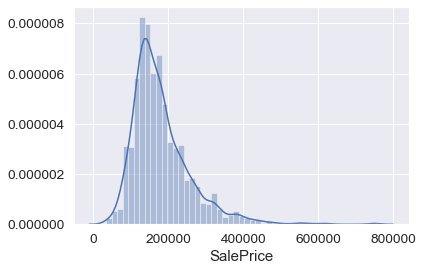

In [1768]:
# plot the response to see its distribution
#histogram
sns.distplot(response)

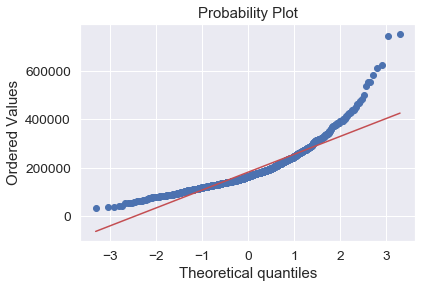

In [1769]:
#qq plot
res = stats.probplot(response, plot=plt)

In [1770]:
# log transformation of response
response = np.log(response)

In [1771]:
print("Skewness:" + str(response.skew()))
print("Kurtosis:" + str(response.kurt()))

Skewness:0.12133506220520406
Kurtosis:0.8095319958036296


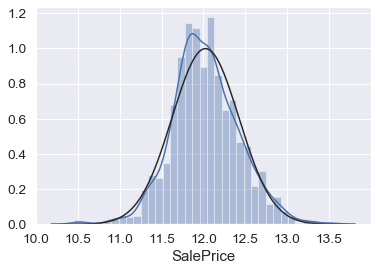

In [1772]:
sns.distplot(response, fit=norm)

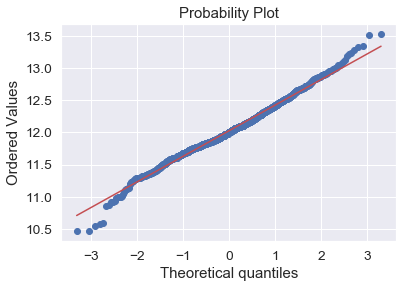

In [1773]:
res = stats.probplot(response, plot=plt)

*After the log transformation, the distribution of response becomes closer to the normal distribution*

### Prepare train

**missing value**

In [1774]:
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
percent.head(20)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
LotConfig       0.000000
dtype: float64

In [1775]:
train.loc[train['PoolArea'] != 0][['PoolArea','PoolQC']]

,PoolArea,PoolQC
Id,,
198,512,Ex
811,648,Fa
1171,576,Gd
1183,555,Ex
1299,480,Gd
1387,519,Fa
1424,738,Gd


In [1776]:
train['PoolQC'] = train['PoolQC'].fillna('NA')

In [1777]:
train['MiscFeature'].value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [1778]:
train.loc[train['MiscFeature']== 'Othr'][['MiscFeature','MiscVal']]

,MiscFeature,MiscVal
Id,,
706,Othr,3500
874,Othr,0


In [1779]:
train['MiscFeature'] = train['MiscFeature'].fillna('NA')

In [1780]:
train['Alley'] = train['Alley'].fillna('NA')

In [1781]:
train['Fence'] = train['Fence'].fillna('NA')

In [1782]:
train.shape

(1460, 79)

**Fill NAs with appropriate contents**

*FireplaceQu*

In [1783]:
np.unique(train['Fireplaces'],return_counts = True)

(array([0, 1, 2, 3]), array([690, 650, 115,   5]))

In [1784]:
train['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [1785]:
train.groupby('Fireplaces')['FireplaceQu'].count()

Fireplaces
0      0
1    650
2    115
3      5
Name: FireplaceQu, dtype: int64

In [1786]:
# all the NAs in FireplaceQu because their Fireplaces is 0, so we can just fill NA into it
# NA is a type of FireplaceQu, means no fireplace

train['FireplaceQu']=train['FireplaceQu'].fillna('NA')

*LotFrontage*

In [1787]:
# LotFrontage is a numerical meature
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].median())

*GarageCond, Garagetype, GarageYrBlt, GarageFinish, GarageQual*

In [1788]:
train.groupby('GarageType')['GarageCond'].count()

GarageType
2Types       6
Attchd     870
Basment     19
BuiltIn     88
CarPort      9
Detchd     387
Name: GarageCond, dtype: int64

In [1789]:
(train.shape[0]-6-870-19-88-9-387)/train.shape[0]

0.05547945205479452

In [1790]:
train['GarageCond']=train['GarageCond'].fillna('NA')
train['GarageType']=train['GarageType'].fillna('NA')
train['GarageYrBlt']=train['GarageYrBlt'].fillna(0)    # ?
train['GarageFinish']=train['GarageFinish'].fillna('NA')
train['GarageQual']=train['GarageQual'].fillna('NA')

*BsmtExposure, BasmtFinType2, BsmtFinType1,BsmtCond,BsmtQual*

In [1791]:
train['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [1792]:
(train.shape[0]-train['BsmtExposure'].value_counts().sum())/train.shape[0]

0.026027397260273973

In [1793]:
train['BsmtExposure']=train['BsmtExposure'].fillna('NA')
train['BsmtFinType2']=train['BsmtFinType2'].fillna('NA')

In [1794]:
train['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [1795]:
(train.shape[0]-train['BsmtFinType1'].value_counts().sum())/train.shape[0]

0.025342465753424658

In [1796]:
train['BsmtFinType1']=train['BsmtFinType1'].fillna('NA')
train['BsmtCond']=train['BsmtCond'].fillna('NA')
train['BsmtQual']=train['BsmtQual'].fillna('NA')

*MasVnrArea, MasVnrType*

In [1797]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [1798]:
(train.shape[0]-train['MasVnrType'].value_counts().sum())/train.shape[0]

0.005479452054794521

In [1799]:
train['MasVnrType'] = train['MasVnrType'].fillna('None')

In [1800]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

*Electrical*

In [1801]:
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [1802]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [1803]:
#check that there's no missing data missing
train.isnull().sum().max()

0

**Features Data Type**

In [1804]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


In [1805]:
train['MSSubClass'] = train['MSSubClass'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [1806]:
train = train.replace({'ExterQual' : {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'ExterCond' : {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'BsmtQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'BsmtCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'BsmtExposure':{'Gd':5, 'Av':4, 'Mn':3, 'No':2, 'NA':1},
                           'BsmtFinType1':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
                           'BsmtFinType2':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
                           'HeatingQC':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'KitchenQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'FireplaceQu':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'GarageFinish':{'Fin':3,'RFn':2,'Unf':1,'NA':0},
                           'GarageQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'GarageCond':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                      })

**Correlation with Y**

In [1807]:
#top correlated variables
corrmat = train_data.corr()

In [1808]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

In [1809]:
cm = np.corrcoef(train_data[cols].values.T)

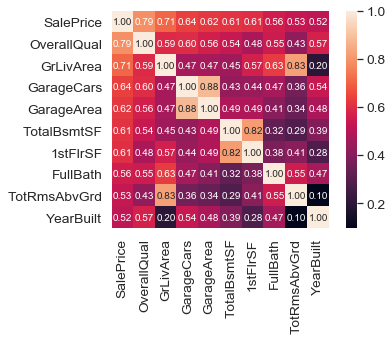

In [1810]:
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Check these top relevant variables**

*numerical features*

In [1811]:
var = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF',
       '1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt']

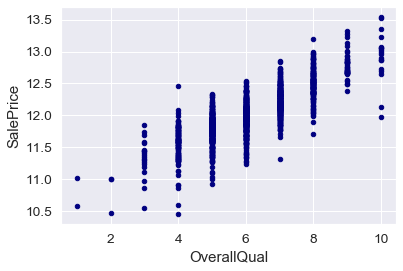

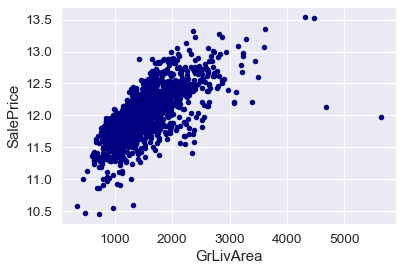

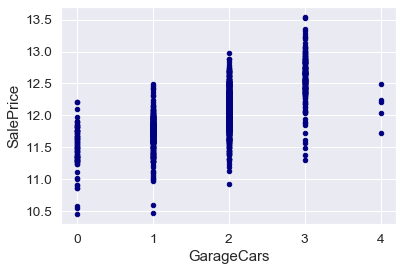

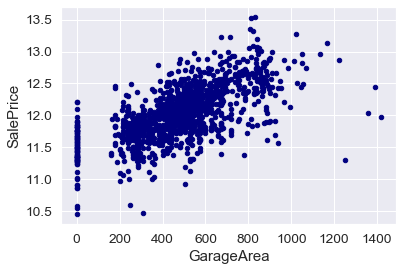

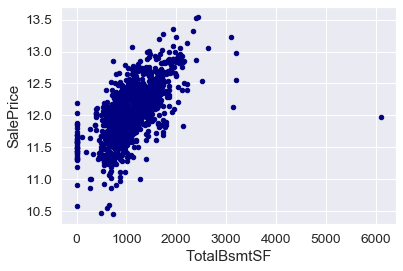

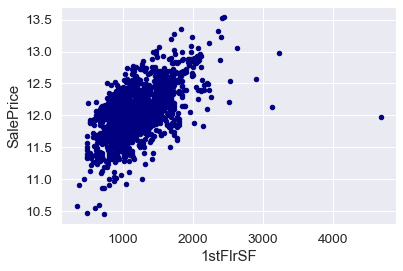

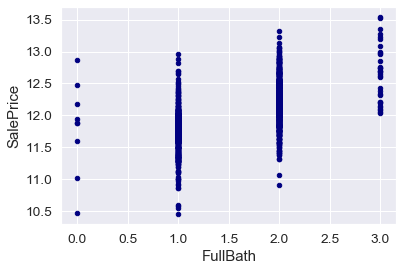

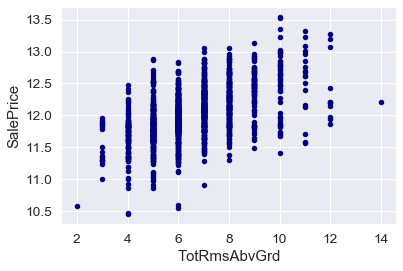

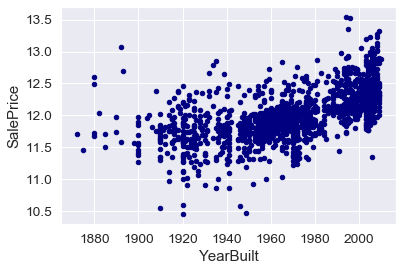

In [1812]:
for i, j in zip(var,range(1,10)):
    data = pd.concat([response, train[i]], axis=1)
    data.plot.scatter(x=i, y='SalePrice',c= 'navy')

In [1813]:
train['GrLivArea'].max()

5642

In [1814]:
train['TotalBsmtSF'].max()

6110

In [1815]:
train['1stFlrSF'].max()

4692

In [1816]:
#GrLivArea, TotalBsmtSF,1stFlrSF
train.loc[train['GrLivArea'] == train['GrLivArea'].max()][['GrLivArea','TotalBsmtSF','1stFlrSF']]

,GrLivArea,TotalBsmtSF,1stFlrSF
Id,,,
1299,5642,6110,4692


*The house with Id 1299 is an outlier in three plots*

In [1817]:
train = train.drop(1299)  # drop the row Id = 1299

In [1818]:
response = response.drop(1299)  # drop the row Id = 1299

In [1819]:
num_var = train.loc[:,train.dtypes != 'object'].columns

In [1820]:
skewness = []
kurtosis = []
for i in num_var:
    skewness.append(train[i].skew())
    kurtosis.append(train[i].kurt())

In [1821]:
df_num = pd.DataFrame({'skewness':skewness, 'kurtosis':kurtosis})
df_num.index = num_var

In [1822]:
#start from high skewness
outlier = df_num[(df_num['skewness']<-1) | (df_num['skewness']>1)]
outlier

,skewness,kurtosis
LotFrontage,1.717171,14.543268
LotArea,12.474542,211.030177
LotShape,-1.284159,1.647513
LandSlope,-4.811833,24.577700
MasVnrArea,2.686371,10.278184
ExterCond,1.396342,6.093646
BsmtQual,-1.291050,4.429677
BsmtCond,-3.699580,18.386836
BsmtExposure,1.105237,-0.122060
BsmtFinType2,3.295574,11.558376


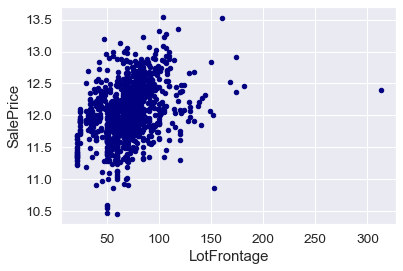

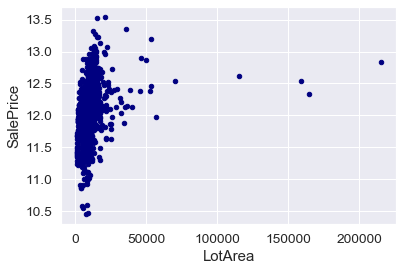

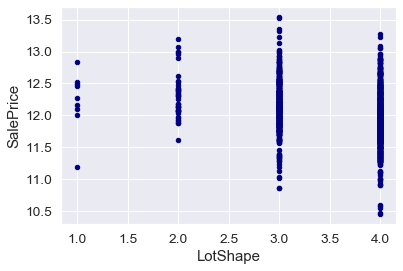

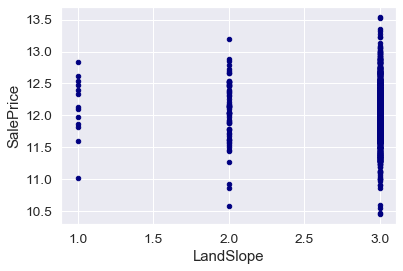

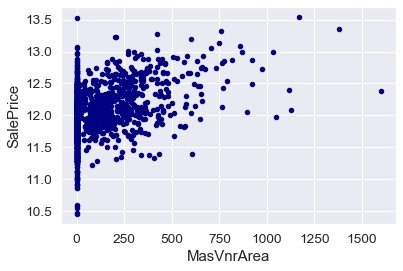

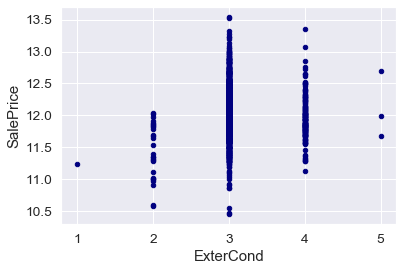

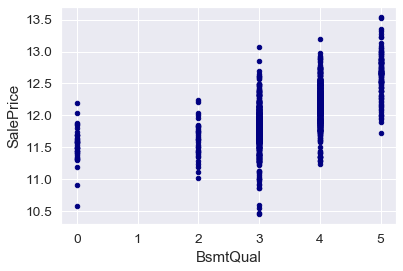

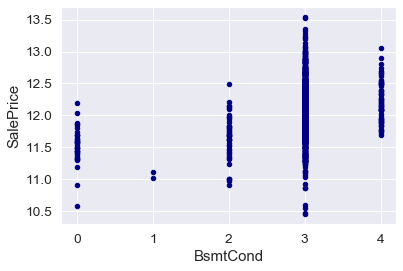

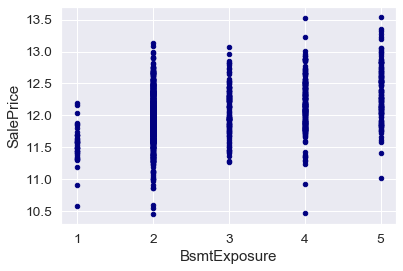

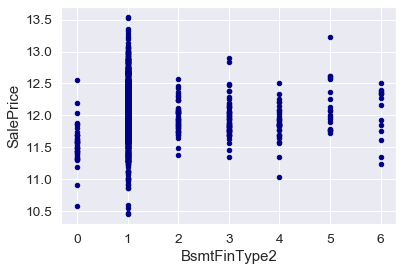

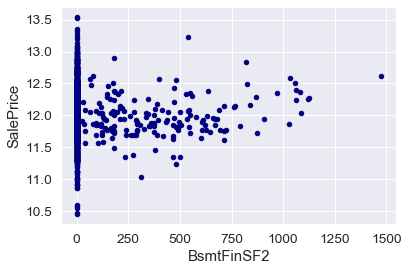

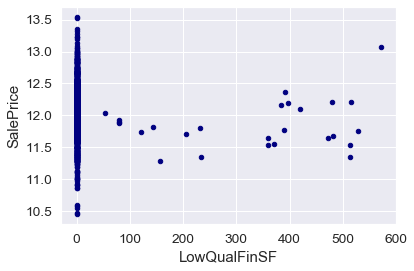

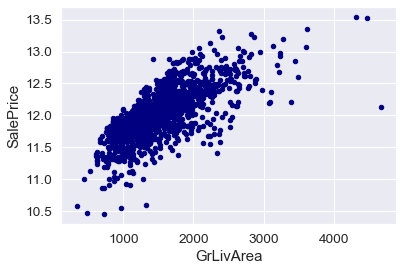

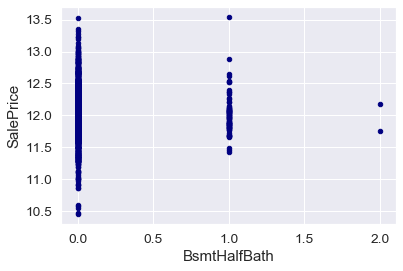

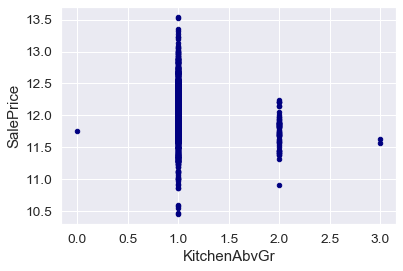

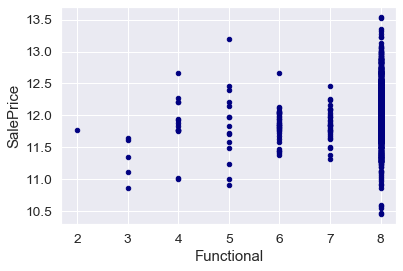

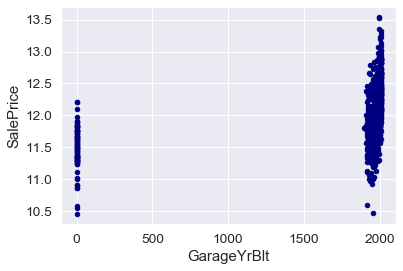

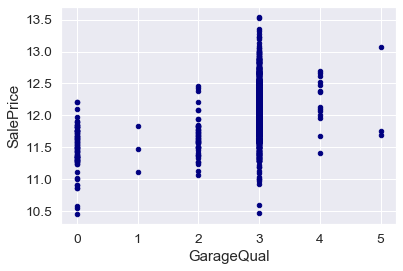

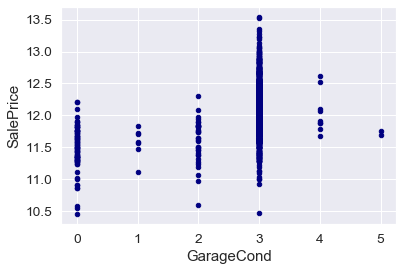

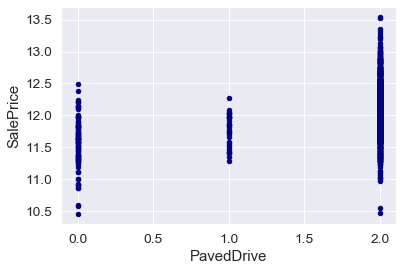

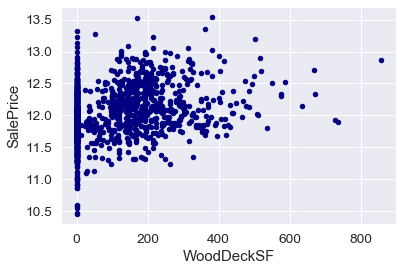

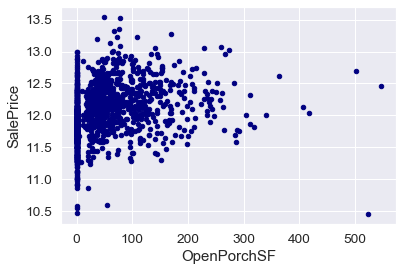

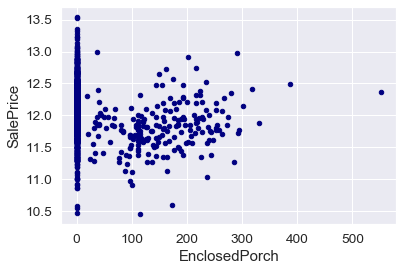

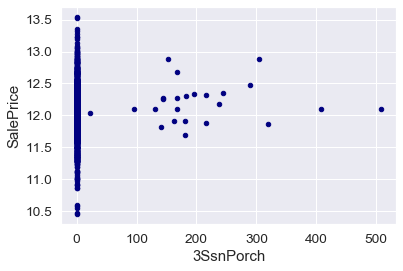

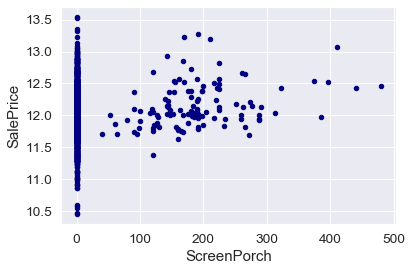

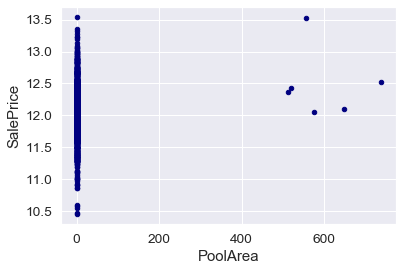

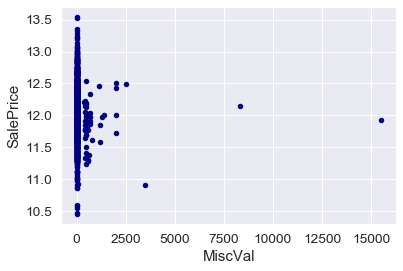

In [1823]:
for i in outlier.index:
    data = pd.concat([response, train[i]], axis=1)
    data.plot.scatter(x=i, y='SalePrice',c='navy')

In [1824]:
# list0 includes variables that have a lot 0s
list0 = ['MasVnrArea','BsmtFinSF2','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch',
         '3SsnPorch','ScreenPorch','PoolArea','MiscVal']

In [1825]:
dict0 = {}
for var in list0:
    dict0[var] = train[var][train[var]!=0].skew()
dict0

{'MasVnrArea': 2.1115176415423806,
 'BsmtFinSF2': 0.9942372017307054,
 'LowQualFinSF': -0.343269681280448,
 'WoodDeckSF': 1.6171986804463157,
 'OpenPorchSF': 2.2625087636174155,
 'EnclosedPorch': 0.864540844780346,
 '3SsnPorch': 1.2870775372725796,
 'ScreenPorch': 1.186468489847003,
 'PoolArea': 1.0986628766902367,
 'MiscVal': 5.058396436020913}

In [1826]:
#'MasVnrArea','WoodDeckSF','OpenPorchSF','3SsnPorch','ScreenPorch','PoolArea','MiscVal' are still high skewness
# log transformation on non-zero data

list1 = ['MasVnrArea','WoodDeckSF','OpenPorchSF','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
for var in list1:
    train[var] = np.log(train[var][train[var]!=0])

In [1827]:
dict1 = {}
for var in list1:
    dict1[var] = train[var][train[var]!=0].skew()
dict1

{'MasVnrArea': -0.5481509869884924,
 'WoodDeckSF': -0.6831819671869803,
 'OpenPorchSF': 0.08626928356193532,
 '3SsnPorch': -1.7295096599220416,
 'ScreenPorch': -0.5036256107669872,
 'PoolArea': 0.9303293940126537,
 'MiscVal': 1.1325694080406807}

In [1828]:
# '3SsnPorch' and 'MiscVal' are still a little skew
for var in list1:
    train[var] = train[var].fillna(0)

In [1829]:
train['MiscVal'].value_counts() # there are more than 96% are 0

0.000000    1407
5.991465      11
6.214608       8
6.551080       5
6.109248       4
6.396930       4
7.600902       4
6.173786       2
7.090077       2
9.024011       1
9.648595       1
6.327937       1
7.244228       1
5.857933       1
3.988984       1
7.170120       1
6.684612       1
7.824046       1
8.160518       1
7.047517       1
6.429719       1
Name: MiscVal, dtype: int64

In [1830]:
train = train.drop(columns = ['MiscVal'])  #?

In [1831]:
# variables in list1 are the variables that are not scores and do not have many 0s
list2 = ['LotFrontage','LotArea','1stFlrSF','GrLivArea']

In [1832]:
for var in list2:
    train[var] = np.log(train[var])

In [1833]:
dict2 = {}
for var in list2:
    dict2[var] = train[var].skew()
dict2

{'LotFrontage': -1.0002416073230112,
 'LotArea': -0.16968080797352356,
 '1stFlrSF': 0.024190871030479195,
 'GrLivArea': -0.047012854418445674}

In [1834]:
# check the skewness and kurtosis again
num_var = train.loc[:,train.dtypes != 'object'].columns
skewness = []
kurtosis = []
for i in num_var:
    skewness.append(train[i].skew())
    kurtosis.append(train[i].kurt())

In [1835]:
df_num = pd.DataFrame({'skewness':skewness, 'kurtosis':kurtosis})
df_num.index = num_var
df_num

,skewness,kurtosis
LotFrontage,-1.000242,3.366829
LotArea,-0.169681,4.716784
LotShape,-1.284159,1.647513
LandSlope,-4.811833,24.577700
OverallQual,0.208957,0.085882
OverallCond,0.692052,1.104076
YearBuilt,-0.612917,-0.439658
YearRemodAdd,-0.502700,-1.273083
MasVnrArea,0.507028,-1.616300
ExterQual,0.823070,0.055780


In [1836]:
train['PoolArea'].value_counts()  # more than 99% are 0

0.000000    1453
6.318968       1
6.603944       1
6.251904       1
6.238325       1
6.356108       1
6.473891       1
Name: PoolArea, dtype: int64

In [1837]:
train = train.drop(columns = ['PoolArea'])

In [1838]:
train['LowQualFinSF'].value_counts()  # more than 98% are 0

0      1433
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

In [1839]:
train = train.drop(columns = ['LowQualFinSF'])

In [1840]:
train.shape

(1459, 76)

In [1841]:
train_cat = train.loc[:,train.dtypes == 'object']
pct=[]
for ix in train_cat.columns:
    temp=train_cat[ix].describe()
    pct.append(temp["freq"]/temp["count"])
skewData=pd.DataFrame(pct,index=train_cat.columns,columns=["skewness"])
skewData=skewData.sort_values(by="skewness",ascending=False)
print (skewData)
train = train.drop((skewData[skewData['skewness'] >= 0.95]).index,1)

               skewness
Utilities      0.999315
PoolQC         0.995888
Street         0.995888
Condition2     0.989719
RoofMatl       0.982865
Heating        0.978067
MiscFeature    0.962988
Alley          0.937629
CentralAir     0.934887
Electrical     0.914325
LandContour    0.898561
SaleType       0.868403
Condition1     0.863605
BldgType       0.835504
SaleCondition  0.821110
Fence          0.807402
MSZoning       0.788211
RoofStyle      0.782042
LotConfig      0.721042
MasVnrType     0.597670
GarageType     0.595613
HouseStyle     0.497601
Foundation     0.442769
MSSubClass     0.367375
Exterior1st    0.352981
Exterior2nd    0.345442
MoSold         0.173406
Neighborhood   0.154215


**categorical variables**

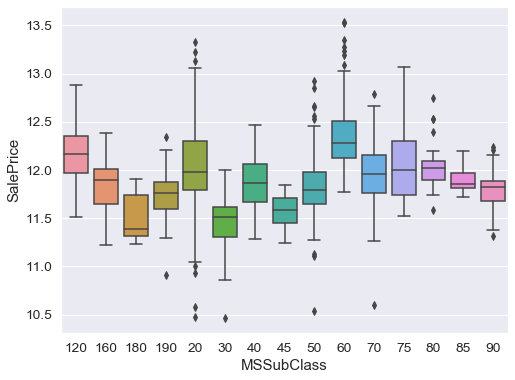

In [1842]:
#boxplot
var = 'MSSubClass'
data = pd.concat([response, train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

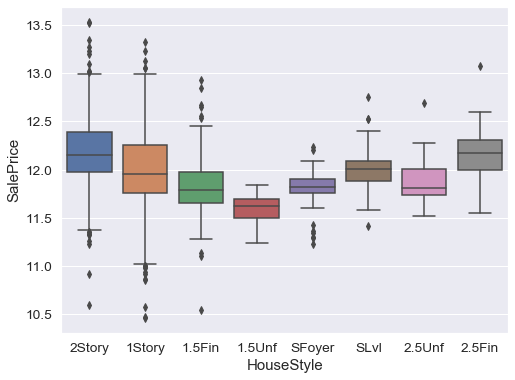

In [1843]:
var = 'HouseStyle'
data = pd.concat([response, train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

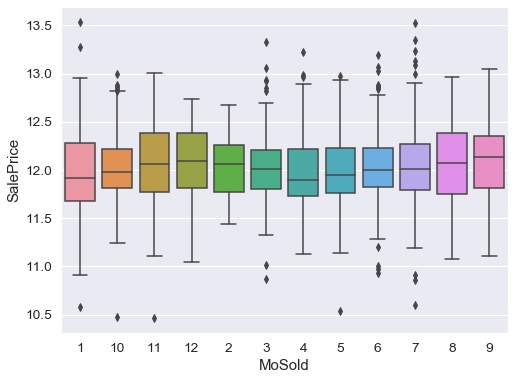

In [1844]:
var = 'MoSold'
data = pd.concat([response, train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

In [1845]:
category = train.loc[:,train.dtypes == object]

for i in category.columns:
    dict_cate = dict({i:category[i].nunique()})
    print(dict_cate)

{'MSSubClass': 15}
{'MSZoning': 5}
{'Alley': 3}
{'LandContour': 4}
{'LotConfig': 5}
{'Neighborhood': 25}
{'Condition1': 9}
{'BldgType': 5}
{'HouseStyle': 8}
{'RoofStyle': 6}
{'Exterior1st': 15}
{'Exterior2nd': 16}
{'MasVnrType': 4}
{'Foundation': 6}
{'CentralAir': 2}
{'Electrical': 5}
{'GarageType': 7}
{'Fence': 5}
{'MoSold': 12}
{'SaleType': 9}
{'SaleCondition': 6}


### PART TWO

**Help functions**

In [1846]:
def RMSE (y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual,y_pred))

In [1847]:
def adjR2(X,y):
    lr=LinearRegression()
    lr.fit(X, y)
    responsePred=lr.predict(X)
    r2=r2_score(y, responsePred)
    p=len(X.columns)+1
    n=len(X)
    return 1-(1-r2)*(n-1)/(n-p-1)

**Feature Engineering**

In [1848]:
#see what most category data are the same
#delete highly skew category data
pct=[]
for ix in category.columns:
    temp=category[ix].describe()
    pct.append(temp["freq"]/temp["count"])
skewData=pd.DataFrame(pct,index=category.columns,columns=["skewness"])
skewData=skewData.sort_values(by="skewness",ascending=False)
print (skewData)

               skewness
Alley          0.937629
CentralAir     0.934887
Electrical     0.914325
LandContour    0.898561
SaleType       0.868403
Condition1     0.863605
BldgType       0.835504
SaleCondition  0.821110
Fence          0.807402
MSZoning       0.788211
RoofStyle      0.782042
LotConfig      0.721042
MasVnrType     0.597670
GarageType     0.595613
HouseStyle     0.497601
Foundation     0.442769
MSSubClass     0.367375
Exterior1st    0.352981
Exterior2nd    0.345442
MoSold         0.173406
Neighborhood   0.154215


In [1849]:
train = train.drop((skewData[skewData['skewness'] >= 0.95]).index,1)

**Feature Simplification**

In [1850]:
category = train.loc[:,train.dtypes == object]

for i in category.columns:
    print(train[i].value_counts(normalize = True))
    print('         ')

20     0.367375
60     0.204249
50     0.098698
120    0.059630
30     0.047293
160    0.043180
70     0.041124
80     0.039753
90     0.035641
190    0.020562
85     0.013708
75     0.010966
45     0.008225
180    0.006854
40     0.002742
Name: MSSubClass, dtype: float64
         
RL         0.788211
RM         0.149417
FV         0.044551
RH         0.010966
C (all)    0.006854
Name: MSZoning, dtype: float64
         
NA      0.937629
Grvl    0.034270
Pave    0.028101
Name: Alley, dtype: float64
         
Lvl    0.898561
Bnk    0.042495
HLS    0.034270
Low    0.024674
Name: LandContour, dtype: float64
         
Inside     0.721042
Corner     0.179575
CulDSac    0.064428
FR2        0.032214
FR3        0.002742
Name: LotConfig, dtype: float64
         
NAmes      0.154215
CollgCr    0.102810
OldTown    0.077450
Edwards    0.067855
Somerst    0.058944
Gilbert    0.054147
NridgHt    0.052776
Sawyer     0.050720
NWAmes     0.050034
SawyerW    0.040439
BrkSide    0.039753
Crawfor    0.0349

In [1851]:
train["Condition1"] = train.Condition1.replace({"RRNe" : "Other", 
                                                  "RRNn" : "Other","PosA" : "Other", 
                                                   "RRAe" : "Other"
                                                  })
train["Electrical"] = train.Electrical.replace({"Mix" : "Other", 
                                                  "FuseP" : "Other"
                                                  })
train["Exterior1st"] = train.Exterior1st.replace({"AsphShn" : "Other", 
                                                  "CBlock" : "Other","ImStucc" : "Other", 
                                                   "BrkComm" : "Other","Stone" : "Other"
                                                  })
train["Exterior2nd"] = train.Exterior2nd.replace({"CBlock" : "Other", 
                                                  "AsphShn" : "Other","Stone" : "Other", 
                                                   "Brk Cmn" : "Other","ImStucc" : "Other"
                                                  })
train["Foundation"] = train.Foundation.replace({"Wood" : "Other", 
                                                  "Stone" : "Other"
                                                  })
#train["Functional"] = train.Functional.replace({"Sev" : "Other", "Maj2":"Other",
                                                 # "Maj1" : "Other"
                                                 # })
train["GarageType"] = train.GarageType.replace({"2Types" : "Other", 
                                                  "CarPort" : "Other"
                                                  })
train["HouseStyle"] = train.HouseStyle.replace({"2.5Fin" : "Other", 
                                                  "2.5Unf" : "Other",
                                                  "1.5Unf" : "Other"
                                                  })
train["MSSubClass"] = train.MSSubClass.replace({"40" : "Other", 
                                                  "180" : "Other",
                                                  "45" : "Other",
                                                 "75" : "Other"
                                                  })
train["MSZoning"] = train.MSZoning.replace({"C (all)" : "Other", 
                                                  "RH" : "Other"
                                                  })
train["Neighborhood"] = train.Neighborhood.replace({"Blueste" : "Other", 
                                                  "NPkVill" : "Other",
                                                  "Veenker" : "Other"
                                                  })
train["RoofStyle"] = train.RoofStyle.replace({"Shed" : "Other", 
                                                  "Mansard" : "Other",
                                                  "Gambrel" : "Other",
                                                  "Flat" : "Other"
                                                  })
train["SaleCondition"] = train.SaleCondition.replace({"AdjLand" : "Other", 
                                                  "Alloca" : "Other"
                                                  })
train["SaleType"] = train.SaleType.replace({"Con" : "Other", 
                                                  "Oth" : "Other",
                                                  "CWD" : "Other", "ConLI" : "Other",
                                                  "ConLw" : "Other","ConLD" : "Other"
                                                  })

In [1852]:
# Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]

# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]

# Overall quality of the basement
train["BsmtGrade"] = train["BsmtQual"] * train["BsmtCond"]

# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]

# Overall garage score
train["GarageScore"] = train["GarageQual"] * train["GarageCond"]

# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
train.drop(["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath"],axis=1)

# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
train.drop(["GrLivArea","TotalBsmtSF"],axis=1)

# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
train.drop(["1stFlrSF","2ndFlrSF"],axis=1)

# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
train.drop(["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"],axis=1)

# Total finished basement SF
train["AllBsmtSF"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]
train.drop(["BsmtFinSF1","BsmtFinSF2"],axis=1)

# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [1853]:
#train_dum = pd.get_dummies(train, columns = train_cat.columns, drop_first = True)

In [1854]:
#train_dum.head()

In [1855]:
# remove collinear columns
# Create correlation matrix
#corr_matrix = train_dum.corr().abs()

# Select upper triangle of correlation matrix
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
#train_dum.drop(to_drop, axis=1, inplace=True)

In [1856]:
#train_dum.shape

In [1857]:
#new_train = train
#new_train['SalePrice'] = response
#corr = new_train.corr()
#corr.sort_values(["SalePrice"], ascending = False, inplace = True)
#high_corr = corr.SalePrice[corr.SalePrice.values>0.6]
#high_corr = high_corr.drop('SalePrice')
#high_corr.index

**Find Polynomial Relationships**

In [1858]:
#train_num = train.loc[:,train.dtypes != 'object']
#X_train_num,X_val_num,y_train_num,y_val_num = train_test_split(train_num,response,test_size=0.3,random_state=42)

In [1859]:
#poly_dict = defaultdict(list)

#for var in high_corr.index:
    #var_train = X_train_num[var]
    #var_test = X_val_num[var]
 
    #for i in range(1,10):
        #form = PolynomialFeatures(degree=i)
        #train_i = form.fit_transform(var_train.values.reshape(-1,1))
        #test_i = form.fit_transform(var_test.values.reshape(-1,1))
        #model = LinearRegression().fit(train_i,y_train)
        #yhat = model.predict(test_i)
        #mse = mean_squared_error(y_val,yhat)
        #poly_dict[var].append(mse)

In [1860]:
#degree = list(range(1,10))
#for i in poly_dict:
    #fig, ax = plt.subplots()
    #ax.plot(degree, poly_dict[i])
    #ax.set_title(i)
    #ax.grid()

In [2219]:
train['OverallQual-5'] = train['OverallQual'] ** 3 #5
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 2
train["ExterQual-8"] = train["ExterQual"] ** 3 #8
train["GarageCars-4"] = train["GarageCars"] ** 4 #4
train["GarageArea-3"] = train["GarageArea"] ** 3
train["AllSF-3"] = train["AllSF"] ** 3
train["GarageFinish-3"] = train["GarageFinish"] ** 3
train["AllBsmtSF-3"] = train["AllBsmtSF"] ** 3
train["BsmtQual-2"] = train["BsmtQual"] ** 2
train["BsmtGrade-9"] = train["BsmtGrade"] ** 4 #9
train["TotalBath-3"] = train["TotalBath"] ** 3 #3
train["OverallGrade-2"] = train["OverallGrade"] ** 2
train['KichenQual-2'] = train['KitchenQual'] ** 2

**Interaction**

In [1862]:
train['CentralAir']

Id
1       Y
2       Y
3       Y
4       Y
5       Y
       ..
1456    Y
1457    Y
1458    Y
1459    Y
1460    Y
Name: CentralAir, Length: 1459, dtype: object

In [1863]:
#train = train.drop(columns = 'SalePrice')

In [2220]:
#turn category features to dummy
train_cat = train.loc[:,train.dtypes == 'object']

In [2221]:
train_dum = pd.get_dummies(train, columns = train_cat.columns, drop_first = True)

In [2222]:
# remove collinear columns
# Create correlation matrix
corr_matrix = train_dum.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [2223]:
# Drop features 
train_dum.drop(to_drop, axis=1, inplace=True)

**Multi-regression Model**

In [2224]:
X_train,X_val,y_train,y_val = train_test_split(train_dum,response,test_size=0.3,random_state=0)

In [2225]:
print("X_train : " + str(X_train.shape))
print("X_val : " + str(X_val.shape))
print("y_train : " + str(y_train.shape))
print("y_val : " + str(y_val.shape))

X_train : (1021, 172)
X_val : (438, 172)
y_train : (1021,)
y_val : (438,)


In [2226]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [2227]:
X1 = sm.add_constant(X_train)
model = sm.OLS(y_train,X1)

In [2228]:
mlr = model.fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     78.03
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:02:22   Log-Likelihood:                 903.28
No. Observations:                1021   AIC:                            -1467.
Df Residuals:                     851   BIC:                            -628.7
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0285      0.003   3512.661      0.0

In [2229]:
mlr.rsquared

0.9393805471171155

In [2230]:
df_pvalue = pd.DataFrame(mlr.pvalues<0.05, columns = ['<0.05'])

In [2231]:
significant = df_pvalue[df_pvalue['<0.05']==True]  # statistical significant variables
significant

,<0.05
const,True
x2,True
x7,True
x16,True
x18,True
x19,True
x20,True
x21,True
x24,True
x31,True


In [2232]:
X2 = sm.add_constant(X_val, has_constant='add')
y_pred_mlr = mlr.predict(X2)

In [2233]:
RMSE(y_pred_mlr,y_val)

0.12309707732669109

### Feature Selection

**Ridge**

In [2234]:
alphas = 10**np.linspace(10,-4,100)
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', cv = 5)
ridgecv.fit(X_train, y_train)
# best alpha 
ridgecv.alpha_

166.81005372000593

In [2235]:
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)

In [2236]:
ridge.score(X_train,y_train)

0.933076324960281

In [2237]:
RMSE(y_val,y_pred_ridge)

0.11447438635089965

**Lasso**

In [2238]:
alphas = 10**np.linspace(10,-16,100)
lassocv = LassoCV(alphas = alphas, cv = 5)
lassocv.fit(X_train, y_train)
# best alpha 
lassocv.alpha_

0.004534878508128573

In [2239]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_val)

In [2240]:
lasso.score(X_train,y_train)

0.927232595817438

In [2241]:
RMSE(y_val,y_pred_lasso)

0.10906378709556887

**XGBoosting**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_val, label = y_val)

param = {'reg_alpha':[1e-3, 1e-2, 0.1, 1, 100, 1000]}

gscv = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1,objective= 'reg:squarederror', seed = 123), 
                    param_grid = param, cv=5)
gscv.fit(X_train, y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, 
                          alpha = gscv.best_params_['reg_alpha'])
xg_reg.fit(X_train, y_train)
y_pred_xg = xg_reg.predict(X_val)
RMSE(y_val, y_pred_xg)

**Random Forest**

In [2213]:
model = RandomForestRegressor(random_state = 0)
params = {'n_estimators':[100,200,300,400],
    'max_features':['auto','sqrt'], 
          'max_depth':[i for i in range(3,6)]}
grid_rf = GridSearchCV(model,param_grid = params, cv = 5)
grid_rf.fit(X_train,y_train)
print(grid_rf.best_params_)
y_pred_rf = grid_rf.predict(X_val)
RMSE(y_val,y_pred_rf)

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}


0.14705407282589622

In [ ]:
y_avg = 0.5*y_pred_ridge + 0.5*y_pred_lasso 
RMSE(y_val, y_avg)

**Decision Tree**

In [ ]:
model = DecisionTreeRegressor(random_state = 0)
params = {'max_features':['auto','sqrt'], 
          'max_depth':[i for i in range(3,15)]}
grid_dt = GridSearchCV(model,param_grid = params, cv = 5)
grid_dt.fit(X_train,y_train)
y_pred_dt = grid_dt.predict(X_val)
RMSE(y_val,y_pred_rf)

**MLP Regressor**

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state = 0, solver = 'adam')
params = {'hidden_layer_sizes': [(100,4),(100,5),(100,6)],
         'activation': ['tanh', 'relu']}
grid_mlp = GridSearchCV(model,param_grid = params, cv = 5)
grid_mlp.fit(X_train,y_train)
print(grid_mlp.best_params_)

y_pred_mlp = grid_mlp.predict(X_val)
RMSE(y_val,y_pred_mlp)

### Try on Test set

In [1974]:
test = pd.read_csv('data/test.csv')

In [1975]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [1976]:
test.index = test['Id']
test = test.drop(columns = 'Id')
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [1977]:
percent_te = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
percent_te.loc[percent_te>0]

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageCond      0.053461
GarageFinish    0.053461
GarageYrBlt     0.053461
GarageQual      0.053461
GarageType      0.052090
BsmtCond        0.030843
BsmtExposure    0.030158
BsmtQual        0.030158
BsmtFinType1    0.028787
BsmtFinType2    0.028787
MasVnrType      0.010966
MasVnrArea      0.010281
MSZoning        0.002742
BsmtHalfBath    0.001371
Utilities       0.001371
Functional      0.001371
BsmtFullBath    0.001371
BsmtFinSF2      0.000685
BsmtFinSF1      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
Exterior2nd     0.000685
SaleType        0.000685
Exterior1st     0.000685
KitchenQual     0.000685
GarageArea      0.000685
GarageCars      0.000685
dtype: float64

In [1978]:
def value(feature):
    return test[feature].value_counts()

In [1979]:
def miss(feature):
    perc = (test.shape[0] - value(feature).sum())/test.shape[0]
    
    if perc == percent_te[feature]:
        return 'same percent'
    
    else:
        return 'diff percent'

In [1980]:
value('PoolQC')

Ex    2
Gd    1
Name: PoolQC, dtype: int64

In [1981]:
test.loc[test['PoolArea'] != 0][['PoolQC','PoolArea']]

,PoolQC,PoolArea
Id,,
1975,Ex,144
2421,NaN,368
2504,NaN,444
2574,Ex,228
2600,NaN,561
2711,Gd,800


In [1982]:
mask = test['PoolArea'] != 0
test.loc[mask, 'PoolQC'] = test.loc[mask, 'PoolQC'].fillna('Ex')

In [1983]:
test['PoolQC'] = test['PoolQC'].fillna('NA')

In [1984]:
test.loc[test['MiscVal'] != 0][['MiscVal','MiscFeature']]

,MiscVal,MiscFeature
Id,,
1462,12500,Gar2
1467,500,Shed
1517,1500,Shed
1519,300,Shed
1569,450,Shed
1594,500,Shed
1606,80,Shed
1620,600,Shed
1629,490,Shed


In [1985]:
test.loc[test['MiscVal'] > 10000][['MiscVal','MiscFeature']]

,MiscVal,MiscFeature
Id,,
1462,12500,Gar2
2550,17000,NaN


In [1986]:
mask = test['MiscVal'] > 10000
test.loc[mask, 'MiscVal'] = test.loc[mask, 'MiscVal'].fillna('Gar2')

In [1987]:
test['MiscFeature'] = test['MiscFeature'].fillna('NA')

In [1988]:
test['Alley'] = test['Alley'].fillna('NA')

In [1989]:
test['Fence'] = test['Fence'].fillna('NA')

In [1990]:
value('FireplaceQu')

Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

In [1991]:
test['FireplaceQu']=test['FireplaceQu'].fillna('NA')

In [1992]:
value('LotFrontage')

60.0     133
80.0      68
70.0      63
50.0      60
75.0      52
        ... 
22.0       1
136.0      1
149.0      1
31.0       1
131.0      1
Name: LotFrontage, Length: 115, dtype: int64

In [1993]:
test['LotFrontage']=test['LotFrontage'].fillna(test['LotFrontage'].median())

In [1994]:
test.loc[(test['GarageCond'].isnull()) & (test['GarageType']=='Detchd')][
        ['GarageType','GarageCond','GarageYrBlt','GarageFinish', 'GarageQual']]

,GarageType,GarageCond,GarageYrBlt,GarageFinish,GarageQual
Id,,,,,
2127,Detchd,NaN,NaN,NaN,NaN
2577,Detchd,NaN,NaN,NaN,NaN


In [1995]:
garagecond = test[test['GarageType'] == 'Detchd']['GarageCond'].mode()[0]

In [1996]:
garageYrBlt = test[test['GarageType'] == 'Detchd']['GarageYrBlt'].mode()[0]

In [1997]:
garagefinish = test[test['GarageType'] == 'Detchd']['GarageFinish'].mode()[0]

In [1998]:
garagequal = test[test['GarageType'] == 'Detchd']['GarageQual'].mode()[0]

In [1999]:
mask = test['GarageType']=='Detchd'
test.loc[mask, 'GarageCond'] = test.loc[mask, 'GarageCond'].fillna(garagecond)

In [2000]:
for i,j in zip(['GarageYrBlt','GarageFinish', 'GarageQual'],
               [garageYrBlt, garagefinish, garagequal]):
    test.loc[mask, i] = test.loc[mask, i].fillna(j)

In [2001]:
test['GarageCond']=test['GarageCond'].fillna('NA')
test['GarageType']=test['GarageType'].fillna('NA')
test['GarageYrBlt']=test['GarageYrBlt'].fillna(0)    
test['GarageFinish']=test['GarageFinish'].fillna('NA')

In [2002]:
test['GarageQual']=test['GarageQual'].fillna('NA')

In [2003]:
test.loc[test['BsmtFinType2'].isnull()][
        ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1', 'BsmtFinType2']]

,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType1,BsmtFinType2
Id,,,,,
1586,NaN,NaN,NaN,NaN,NaN
1594,NaN,NaN,NaN,NaN,NaN
1730,NaN,NaN,NaN,NaN,NaN
1779,NaN,NaN,NaN,NaN,NaN
1815,NaN,NaN,NaN,NaN,NaN
1848,NaN,NaN,NaN,NaN,NaN
1849,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN
1858,NaN,NaN,NaN,NaN,NaN


In [2004]:
test.loc[(test['BsmtCond'] == 'TA') & (test['BsmtExposure'] == 'No') & 
         (test['BsmtFinType1'] == 'Unf') & (test['BsmtFinType2'] == 'Unf')]['BsmtQual'].mode()[0]

'TA'

In [2005]:
mask = (test['BsmtCond'] == 'TA') & (test['BsmtExposure'] == 'No') & (
    test['BsmtFinType1'] == 'Unf') & (test['BsmtFinType2'] == 'Unf')
test.loc[mask, 'BsmtQual'] = test.loc[mask, 'BsmtQual'].fillna('TA')

In [2006]:
test['BsmtExposure']=test['BsmtExposure'].fillna('NA')
test['BsmtFinType2']=test['BsmtFinType2'].fillna('NA')
test['BsmtFinType1']=test['BsmtFinType1'].fillna('NA')
test['BsmtCond']=test['BsmtCond'].fillna('NA')
test['BsmtQual']=test['BsmtQual'].fillna('NA')

In [2007]:
value('MasVnrType')

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [2008]:
miss('MasVnrType')

'same percent'

In [2009]:
test.loc[test['MasVnrType'].isnull()][
        ['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
1692,NaN,NaN
1707,NaN,NaN
1883,NaN,NaN
1993,NaN,NaN
2005,NaN,NaN
2042,NaN,NaN
2312,NaN,NaN
2326,NaN,NaN
2341,NaN,NaN


In [2010]:
test.loc[test['MasVnrArea'] == 198]['MasVnrType'].mode()[0]

'Stone'

In [2011]:
mask = test['MasVnrArea'] == 198
test.loc[mask, 'MasVnrType'] = test.loc[mask, 'MasVnrType'].fillna('Stone')

In [2012]:
test['MasVnrType'] = test['MasVnrType'].fillna('None') 
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [2013]:
value('MSZoning')

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

In [2014]:
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])

In [2015]:
value('BsmtHalfBath')

0.0    1364
1.0      91
2.0       2
Name: BsmtHalfBath, dtype: int64

In [2016]:
test.loc[test['TotalBsmtSF'].isnull()][
        ['BsmtHalfBath','BsmtFullBath','TotalBsmtSF',
         'BsmtUnfSF','BsmtFinSF1','BsmtFinSF2','BsmtCond',
         'BsmtExposure','BsmtQual','BsmtFinType1', 'BsmtFinType2']]

,BsmtHalfBath,BsmtFullBath,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType1,BsmtFinType2
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA,NA,NA,NA


In [2017]:
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)

In [2018]:
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)

In [2019]:
value('Exterior2nd')

VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      21
AsbShng     18
Brk Cmn     15
ImStucc      5
CBlock       2
AsphShn      1
Stone        1
Name: Exterior2nd, dtype: int64

In [2020]:
test.loc[test['Exterior2nd'].isnull()][['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
Id,,
2152,NaN,NaN


In [2021]:
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])

In [2022]:
value('SaleType')

WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
Con         3
ConLw       3
Name: SaleType, dtype: int64

In [2023]:
test.loc[test['SaleCondition'] == 'Normal']['SaleType'].mode()[0]

'WD'

In [2024]:
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

In [2025]:
value('KitchenQual')

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [2026]:
test.loc[test['KitchenQual'].isnull()]['KitchenAbvGr']

Id
1556    1
Name: KitchenAbvGr, dtype: int64

In [2027]:
test.loc[test['KitchenAbvGr'] == 1]['KitchenQual'].mode()[0]

'TA'

In [2028]:
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])

In [2029]:
test.loc[test['GarageCars'].isnull()][[
    'GarageCars', 'GarageArea','GarageYrBlt','GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']]

,GarageCars,GarageArea,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageType
Id,,,,,,,
2577,NaN,NaN,1950.0,Unf,TA,TA,Detchd


In [2030]:
test.loc[(test['GarageYrBlt'] == 1950) & (test['GarageFinish'] == 'Unf') & (
    test['GarageQual'] == 'TA') & (test['GarageCond'] == 'TA') & (test['GarageType'] == 'Detchd')][
    'GarageCars'].mode()[0]

1.0

In [2031]:
test['GarageCars'] =  test['GarageCars'].fillna(1)

In [2032]:
test.loc[(test['GarageYrBlt'] == 1950) & (test['GarageFinish'] == 'Unf') & (
    test['GarageQual'] == 'TA') & (test['GarageCond'] == 'TA') & (test['GarageType'] == 'Detchd')][
    'GarageArea'].median()

360.0

In [2033]:
test['GarageArea'] =  test['GarageArea'].fillna(360)

In [2034]:
value('Utilities')

AllPub    1457
Name: Utilities, dtype: int64

In [2035]:
test['Utilities'] = test['Utilities'].fillna(test['Utilities'].mode()[0])

In [2036]:
value('Functional')

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [2037]:
test['Functional'] = test['Functional'].fillna(test['Functional'].mode()[0])

In [2038]:
test.isnull().sum().max()

0

In [2039]:
test['MSSubClass'] = test['MSSubClass'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)
test = test.replace({'ExterQual' : {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'ExterCond' : {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'BsmtQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'BsmtCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'BsmtExposure':{'Gd':5, 'Av':4, 'Mn':3, 'No':2, 'NA':1},
                           'BsmtFinType1':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
                           'BsmtFinType2':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
                           'HeatingQC':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'KitchenQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
                           'FireplaceQu':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'GarageFinish':{'Fin':3,'RFn':2,'Unf':1,'NA':0},
                           'GarageQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                           'GarageCond':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                            "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                            "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2}})

In [2040]:
for var in list1:
    test[var] = np.log(test[var][test[var]!=0])

In [2041]:
for var in list1:
    test[var] = test[var].fillna(0)

In [2042]:
for var in list2:
    test[var] = np.log(test[var])

In [2043]:
test = test.drop(columns = ['MiscVal'])

In [2044]:
test = test.drop(columns = ['PoolArea','LowQualFinSF'])

In [2045]:
test = test.drop(columns = ['Utilities','PoolQC','Street','Condition2','RoofMatl','Heating', 'MiscFeature'])

In [2046]:
test["Condition1"] = test.Condition1.replace({"RRNe" : "Other", 
                                                  "RRNn" : "Other","PosA" : "Other", 
                                                   "RRAe" : "Other"
                                                  })
test["Electrical"] = test.Electrical.replace({"Mix" : "Other", 
                                                  "FuseP" : "Other"
                                                  })
test["Exterior1st"] = test.Exterior1st.replace({"AsphShn" : "Other", 
                                                  "CBlock" : "Other","ImStucc" : "Other", 
                                                   "BrkComm" : "Other","Stone" : "Other"
                                                  })
test["Exterior2nd"] = test.Exterior2nd.replace({"CBlock" : "Other", 
                                                  "AsphShn" : "Other","Stone" : "Other", 
                                                   "Brk Cmn" : "Other","ImStucc" : "Other"
                                                  })
test["Foundation"] = test.Foundation.replace({"Wood" : "Other", 
                                                  "Stone" : "Other"
                                                  })
#test["Functional"] = test.Functional.replace({"Sev" : "Other", "Maj2":"Other",
                                                  #"Maj1" : "Other"
                                                  #})
test["GarageType"] = test.GarageType.replace({"2Types" : "Other", 
                                                  "CarPort" : "Other"
                                                  })
test["HouseStyle"] = test.HouseStyle.replace({"2.5Fin" : "Other", 
                                                  "2.5Unf" : "Other",
                                                  "1.5Unf" : "Other"
                                                  })
test["MSSubClass"] = test.MSSubClass.replace({"40" : "Other", 
                                                  "180" : "Other",
                                                  "45" : "Other",
                                                  "75" : "Other",
                                             "150" : "Other",
                                                  })
test["MSZoning"] = test.MSZoning.replace({"C (all)" : "Other", 
                                                  "RH" : "Other"
                                                  })
test["Neighborhood"] = test.Neighborhood.replace({"Blueste" : "Other", 
                                                  "NPkVill" : "Other",
                                                  "Veenker" : "Other"
                                                  })
test["RoofStyle"] = test.RoofStyle.replace({"Shed" : "Other", 
                                                  "Mansard" : "Other",
                                                  "Gambrel" : "Other",
                                                  "Flat" : "Other"
                                                  })
test["SaleCondition"] = test.SaleCondition.replace({"AdjLand" : "Other", 
                                                  "Alloca" : "Other"
                                                  })
test["SaleType"] = test.SaleType.replace({"Con" : "Other", 
                                                  "Oth" : "Other",
                                                  "CWD" : "Other", "ConLI" : "Other",
                                                  "ConLw" : "Other","ConLD" : "Other"
                                                  })

In [2047]:
# Combinations of existing features
# Overall quality of the house
test["OverallGrade"] = test["OverallQual"] * test["OverallCond"]

# Overall quality of the exterior
test["ExterGrade"] = test["ExterQual"] * test["ExterCond"]

# Overall quality of the basement
test["BsmtGrade"] = test["BsmtQual"] * test["BsmtCond"]

# Overall kitchen score
test["KitchenScore"] = test["KitchenAbvGr"] * test["KitchenQual"]

# Overall garage score
test["GarageScore"] = test["GarageQual"] * test["GarageCond"]

# Total number of bathrooms
test["TotalBath"] = test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]) + \
test["FullBath"] + (0.5 * test["HalfBath"])
test.drop(["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath"],axis=1)

# Total SF for house (incl. basement)
test["AllSF"] = test["GrLivArea"] + test["TotalBsmtSF"]
test.drop(["GrLivArea","TotalBsmtSF"],axis=1)

# Total SF for 1st + 2nd floors
test["AllFlrsSF"] = test["1stFlrSF"] + test["2ndFlrSF"]
test.drop(["1stFlrSF","2ndFlrSF"],axis=1)

# Total SF for porch
test["AllPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + \
test["3SsnPorch"] + test["ScreenPorch"]
test.drop(["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"],axis=1)

# Total finished basement SF
test["AllBsmtSF"] = test["BsmtFinSF1"] + test["BsmtFinSF2"]
test.drop(["BsmtFinSF1","BsmtFinSF2"],axis=1)

test["BoughtOffPlan"] = test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [2244]:
test['OverallQual-5'] = test['OverallQual'] ** 3#5
test["AllFlrsSF-2"] = test["AllFlrsSF"] ** 2
test["GrLivArea-3"] = test["GrLivArea"] ** 2
test["ExterQual-8"] = test["ExterQual"] ** 3 #8
test["GarageCars-4"] = test["GarageCars"] ** 4
test["GarageArea-3"] = test["GarageArea"] ** 3
test["AllSF-3"] = test["AllSF"] ** 3
test["GarageFinish-3"] = test["GarageFinish"] ** 3
test["AllBsmtSF-3"] = test["TotalBsmtSF"] ** 3
test["BsmtQual-2"] = test["BsmtQual"] ** 2
test["BsmtGrade-9"] = test["BsmtGrade"] ** 4 #9
test["TotalBath-3"] = test["TotalBath"] ** 3
test["OverallGrade-2"] = test["OverallGrade"] ** 2
test['KichenQual-2'] = test['KitchenQual'] ** 2

In [2245]:
test_cat = test.loc[:,test.dtypes == 'object']

In [2246]:
test_dum = pd.get_dummies(test,columns = test_cat.columns, drop_first = True)
test_dum.drop(to_drop, axis=1, inplace=True)

**Bagging**

In [2247]:
ridge_list, lasso_list, rf_list = [],[],[]
for t in range(500):
    test_bag = []
    
    for i in test_dum.columns:
        sample = np.random.choice(test_dum[i], replace = True, size = 1459)
        test_bag.append(sample)
        
    test_sample = np.array(test_bag).T
    test_sample = scaler.transform(test_sample)

    y_pred_ridge = ridge.predict(test_sample)
    y_pred_lasso = lasso.predict(test_sample)
    #y_pred_rf = grid_rf.predict(test_sample)

    ridge_list.append(y_pred_ridge)
    lasso_list.append(y_pred_lasso)
    #rf_list.append(y_pred_rf)

In [2248]:
mean_ridge = pd.DataFrame(ridge_list).T.mean(axis=1)

In [2249]:
mean_ridge

0       11.996217
1       12.007545
2       12.005329
3       12.006710
4       12.002761
          ...    
1454    12.003756
1455    12.012203
1456    11.999538
1457    12.007860
1458    12.009597
Length: 1459, dtype: float64

In [2250]:
mean_lasso = pd.DataFrame(lasso_list).T.mean(axis=1)
mean_lasso

0       11.998636
1       12.010525
2       12.014829
3       12.007675
4       12.009273
          ...    
1454    12.011098
1455    12.020540
1456    12.014573
1457    12.013875
1458    12.018888
Length: 1459, dtype: float64

In [2054]:
#y_pred_ridge = ridge.predict(test_dum)
#y_pred_lasso = lasso.predict(test_dum)
#y_pred_mlr = mlr.predict(test_dum)
#y_pred_xg = xg_reg.predict(test_dum)
#y_pred_rf = grid_rf.predict(test_dum)
#y_pred_dt = grid_dt.predict(test_dum)

In [2055]:
#y_pred_ridge

array([11.5877705 , 12.00343762, 12.08777946, ..., 12.02755421,
       11.64721677, 12.26942783])

In [2251]:
y_pred_ridge = np.exp(mean_ridge)
y_pred_lasso = np.exp(y_pred_lasso)
#y_pred_mlr = np.exp(y_pred_mlr)
#y_pred_xg = np.exp(y_pred_xg)
#y_pred_rf = np.exp(y_pred_rf)
#y_pred_dt = np.exp(y_pred_dt)

In [2252]:
result1 = pd.DataFrame({'ridge':y_pred_ridge, 'lasso': y_pred_lasso}) #'xg': y_pred_xg,
                        #'rf':y_pred_rf})
result1.index = test.index
result1

,ridge,lasso
Id,,
1461,162140.175070,174949.470328
1462,163987.352371,152803.853271
1463,163624.361933,168904.107491
1464,163850.501974,186343.327895
1465,163204.814361,188081.696301
...,...,...
2915,163367.220718,145240.607174
2916,164753.116579,130386.030641
2917,162679.628350,143184.907294


In [2156]:
#result_scale = pd.DataFrame({'SalePrice' : y_pred_ridge})

In [2157]:
#result_scale.index = test.index
#result_scale

,SalePrice
Id,
1461,1.850295e+06
1462,1.863014e+06
1463,1.867827e+06
1464,1.884672e+06
1465,1.862321e+06
...,...
2915,1.033520e+05
2916,1.036930e+05
2917,1.036877e+05


In [2158]:
#result_scale.to_csv('submission.csv')

In [2253]:
result1['SalePrice'] = (0.6*result1['ridge'] + 0.4*result1['lasso'])*0.67

In [2254]:
result = result1['SalePrice']

In [2255]:
result

Id
1461    112066.808426
1462    106874.348330
1463    111043.294305
1464    115807.913669
1465    116014.229982
            ...      
2915    104598.105451
2916    101174.209077
2917    103770.765752
2918    107503.180771
2919    111700.577853
Name: SalePrice, Length: 1459, dtype: float64

In [2256]:
result.to_csv('submission.csv')

In [2257]:
jgd = [2,7,3,4]

In [2258]:
jgd[1:]

[7, 3, 4]